In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statistics import stdev
import statsmodels
from statsmodels.sandbox.stats.multicomp import multipletests
import imblearn
import sys
from numpy import mean, absolute, sqrt
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors
import sklearn.preprocessing
from xgboost import XGBClassifier
import sklearn.ensemble
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import GaussianNB
from itertools import combinations, cycle
import time

# Define features

In [2]:
list_features = ['AK1C1','TAU', '1433G', 'SCUB1', 'FMOD', 'AMYP', 'CRIS3', 
                'MYDGF', 'RARR2', 'ATS8', 'PGK1', '1433Z', 'SV2A', 'TRH', 'GUAD', 
                'HV69D', 'CO7', 'SERC']

list_features_plus_biomarkers = ['AK1C1','TAU', '1433G', 'SCUB1', 'FMOD', 'AMYP', 'CRIS3', 
                'MYDGF', 'RARR2', 'ATS8', 'PGK1', '1433Z', 'SV2A', 'TRH', 'GUAD', 
                'HV69D', 'CO7', 'SERC', 'AB42/AB40', 'Ttau (pg/ml)']

list_features_plus_ab42 = ['AK1C1','TAU', '1433G', 'SCUB1', 'FMOD', 'AMYP', 'CRIS3', 
                'MYDGF', 'RARR2', 'ATS8', 'PGK1', '1433Z', 'SV2A', 'TRH', 'GUAD', 
                'HV69D', 'CO7', 'SERC', 'AB42/AB40']

list_features_plus_tau = ['AK1C1','TAU', '1433G', 'SCUB1', 'FMOD', 'AMYP', 'CRIS3', 
                'MYDGF', 'RARR2', 'ATS8', 'PGK1', '1433Z', 'SV2A', 'TRH', 'GUAD', 
                'HV69D', 'CO7', 'SERC', 'Ttau (pg/ml)']


list_features_ab42 = ['AB42/AB40']

list_features_tau = ['Ttau (pg/ml)']

list_features_both = ['AB42/AB40', 'Ttau (pg/ml)']

feature_options=[list_features, list_features_plus_ab42, list_features_plus_tau, 
                 list_features_plus_biomarkers, 
                 list_features_ab42, list_features_tau, list_features_both]

classes_of_interest=['Healthy', 'PD_MCI_LBD', 'PD', 'AD_MCI']


# Functions I used
I copied and pasted the functions I needed directly in this notebook-- but once this is finalized, I would import them instead.

In [3]:
def handle_scale_and_nan(df, nan_decision='drop'):
    features = list(df.select_dtypes(include='float64'))
    cat = list(df.select_dtypes(include='object'))
    scaler = sklearn.preprocessing.StandardScaler().fit(df[features])
    df_cont = pd.DataFrame(data=scaler.transform(df[features]), columns=features)
    df_cat = pd.DataFrame(data=df[cat], columns=cat)
    
    df = pd.concat([df_cat,df_cont],axis=1)
    
    if nan_decision == 'mean':
        for feature in features:
            df[feature].fillna((df[feature].mean()), inplace=True)
    elif nan_decision == 'drop':
            df = df.dropna(axis=1)
    elif nan_decision == 'impute':
        imputer = missingpy.MissForest() #must be in shape of n_samples by n_features
        df = imputer.fit_transform(df[:, 1:]) # impute NaNs with existing numerical vals
        df.insert(0, "group", df[:, 0], allow_duplicates=True) # reinsert the nominal vals
    elif nan_decision == 'replace_ones': 
        df.fillna(value=1)
        
    return df

def over_under(df_train,cat_in_excess='Healthy',target='group',randomstate=np.random.randint(0,4294967295)):
    """
    Takes dataframe(s) with only the target value and float64 features
    This function is to balance the samples in an imbalanced training dataset that has one category in excess, with additional categories more near each other
    The categories below the category in excess will be oversampled to equality, then the category in excess will be undersampled to equality
    ---Parameters---
    df_train: the training dataframe
    cat_in_excess: the category which is present in excess, far above the other categories
    target: target column in the dataframe
    randomstate: if chosen, this will the random state for the sampling. Default: None, numpy random integer method between 0 and 4294967295, the range of the sampling module used
    randomstate_sampler: the number of loops to run to compare random states starting from 
    """
    # Drop the excessive category and oversample minority to the intermediate category
    df_train_no_excess = df_train[df_train.group != cat_in_excess]
    over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
    X_train = df_train_no_excess.drop(columns=target)
    y_train = df_train_no_excess[target]
    X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
    df_train_over = pd.concat([y_train_over,X_train_over],axis=1)

    # Re-introduce the excessive category and undersample the majority to the minority
    df_train_excess = pd.concat([df_train_over,df_train[df_train[target] == cat_in_excess]])
    under_sampler = imblearn.under_sampling.RandomUnderSampler(random_state=randomstate)
    X_train = df_train_excess.drop(columns=target)
    y_train = df_train_excess[target]
    X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
    df_train_eq = pd.concat([y_train_under,X_train_under],axis=1)
    
    return df_train_eq

def apply_ml_model(dev,classifier,scoring_method='balanced_accuracy',target='group', cv=10, feature_list=list_features):
    """
    Finds the score for different ML classifiers
    Takes a dataframe with only target and feature columns
    dev : the development dataframe with a single categorical target column and float64 features
    classifier: ML classifier to test.
        options: "random_forest', "naive_bayes", "decision_tree"
    scoring_method: method of scoring the classifier
        run sklearn.metrics.get_scorer_names() to get a list of scoring methods
    target: target categorical column
    cv: folds to run in evaluation. takes integers or 'max': will run maximum number of folds = # of samples in categories
    """
    # define predictor and response variables
    X = dev[feature_list]
    y = dev[target]
    
    # check that the data has equal number of categories in training data
    counts_list = list(dev['group'].value_counts())
    assert len(set(counts_list)) == 1, 'training data should contain equal quantities of categories. run bp_preprocessing.over_under() or other balancer'
    
    
    # choose model based on user input
    if classifier == "random_forest": 
        model = sklearn.ensemble.RandomForestClassifier()
    elif classifier == "naive_bayes":  
        model = sklearn.naive_bayes.GaussianNB()
    elif classifier == "decision_tree": 
        model = sklearn.tree.DecisionTreeClassifier()
    elif classifier == "xgboost": 
        model = XGBClassifier()
    else: 
        print("wrong classifier named entered")
    #define cv quantity:
    if type(cv) == int:
        pass
    elif cv == 'max':
        cv = counts_list[0]
    else:
        raise TypeError('Enter an integer or "max" as a string')
        
    scores = cross_val_score(model, X, y, scoring=scoring_method,cv=cv)
    mean_score = np.mean(absolute(scores))
    std = np.std(scores)
    stats_list = [cv, scores, mean_score, std , model, scoring_method, feature_list[-2:]]
    stats_df = pd.DataFrame(data=[stats_list], columns=['folds','scores','abs_avg_score','std','model','scoring_method', 'features'])
    
    return stats_df



In [4]:
def add_biomarkers_as_features(compiled_metadata, data_dev, data_test): 

    compiled_metadata = compiled_metadata.set_index("Public Sample ID")
    compiled_metadata = compiled_metadata.sort_index()
    compiled_metadata = compiled_metadata.dropna(axis = 0, how = 'all')
    compiled_metadata = compiled_metadata[(compiled_metadata.Condition != 'Golden West CSF Batch QC')]
    compiled_metadata = compiled_metadata[compiled_metadata.Condition != 'Lumbar CSF Pool Batch Ref']

    compiled_metadata = compiled_metadata[['Condition', 'Ttau (pg/ml)', 'AB42 (pg/ml)']]
    
    dict_AB42_ratio = {}
    for i, j in zip(compiled_metadata.index, compiled_metadata['AB42 (pg/ml)']): 
        dict_AB42_ratio[i]= j

    dict_tau = {}
    for i, j in zip(compiled_metadata.index, compiled_metadata['Ttau (pg/ml)']): 
        dict_tau[i]= j

    data_dev['AB42/AB40'] = data_dev['assay_ID'].map(dict_AB42_ratio)
    data_dev['Ttau (pg/ml)'] = data_dev['assay_ID'].map(dict_tau)

    data_test['AB42/AB40'] = data_test['assay_ID'].map(dict_AB42_ratio)
    data_test['Ttau (pg/ml)'] = data_test['assay_ID'].map(dict_tau)
    
    return data_dev, data_test

In [5]:
def pre_process_data(data_dev, data_test): 
    data_dev = handle_scale_and_nan(data_dev)
    data_test = handle_scale_and_nan(data_test)
    data_dev = data_dev.drop(columns='assay_ID')
    data_test = data_test.drop(columns='assay_ID')
    data_dev = over_under(data_dev) #split groups equally 
    return data_dev, data_test

def make_confusion_mtrx(dev, data_test, features=list_features):
    test_X = data_test[list_features]
    test_y = data_test['group']

    dev_X = dev[list_features]
    dev_y = dev.iloc[:,0] # 0th column is our target

    model = sklearn.ensemble.RandomForestClassifier()
    model.fit(dev_X, dev_y) 
    print('score=', sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))
    ConfusionMatrixDisplay.from_estimator(model, test_X, test_y)
    plt.show()

In [6]:
def roc_curves_one_vs_rest(data_dev, data_test, list_features=list_features_plus_biomarkers):
    data_dev, data_test = pre_process_data(data_dev, data_test)
    
    dev = data_dev[list_features]
    dev.insert(0, "group", data_dev['group'], True)
    
    X_test = data_test[list_features]
    y_test = data_test['group']

    X_train = dev.iloc[:,1:] 
    y_train = dev.iloc[:,0] # 0th column is our target


    classifier = sklearn.ensemble.RandomForestClassifier()
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fig, ax = plt.subplots(figsize=(6, 6))
    
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", 'red'])
    for class_id, color in zip(range(4), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {classes_of_interest[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if len(list_features)==20: 
        plt.title(f"One-vs-Rest ROC curves, using 18 features + {list_features[-2:]}")
    elif len(list_features)==18:
        plt.title(f"One-vs-Rest ROC curves, using 18 features")
    elif len(list_features)==19:
        plt.title(f"One-vs-Rest ROC curves, using 18 features + {list_features[-1:]}")
    else: 
        plt.title(f"One-vs-Rest ROC curves, using {list_features}")
        
    plt.legend()
    plt.show()

In [7]:
def roc_curve_one_vs_one(data_dev, data_test, list_features): 
    pair_scores = []
    mean_tpr = dict()
    pair_list = list(combinations(np.unique(classes_of_interest), 2))
    
    data_dev, data_test = pre_process_data(data_dev, data_test)
    dev = data_dev[list_features]
    dev.insert(0, "group", data_dev['group'], True)
    
    X_test = data_test[list_features]
    y_test = data_test['group']

    X_train = dev.iloc[:,1:] 
    y_train = dev.iloc[:,0] # 0th column is our target


    classifier = sklearn.ensemble.RandomForestClassifier()
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    label_binarizer = LabelBinarizer().fit(y_train)
    
    for ix, (label_a, label_b) in enumerate(pair_list):

        a_mask = y_test == label_a
        b_mask = y_test == label_b
        ab_mask = np.logical_or(a_mask, b_mask)

        a_true = a_mask[ab_mask]
        b_true = b_mask[ab_mask]

        idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
        idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

        fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
        fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

        fpr_grid = np.linspace(0.0, 1.0, 1000)

        mean_tpr[ix] = np.zeros_like(fpr_grid)
        mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
        mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
        mean_tpr[ix] /= 2
        mean_score = auc(fpr_grid, mean_tpr[ix])
        pair_scores.append(mean_score)

        fig, ax = plt.subplots(figsize=(6, 6))
        plt.plot(
            fpr_grid,
            mean_tpr[ix],
            label=f"Mean {label_a} vs {label_b} (AUC = {mean_score :.2f})",
            linestyle=":",
            linewidth=4,
        )
        RocCurveDisplay.from_predictions(
            a_true,
            y_score[ab_mask, idx_a],
            ax=ax,
            name=f"{label_a} as positive class",
        )
        RocCurveDisplay.from_predictions(
            b_true,
            y_score[ab_mask, idx_b],
            ax=ax,
            name=f"{label_b} as positive class",
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")

        if len(list_features)==20: 
            plt.title(f"{label_a} vs {label_b} ROC curves, using 18 features + {list_features[-2:]}")
        elif len(list_features)==18:
            plt.title(f"{label_a} vs {label_b} ROC curves, using 18 features")
        elif len(list_features)==19:
            plt.title(f"{label_a} vs {label_b} ROC curves, using 18 features + {list_features[-1:]}")
        else: 
            plt.title(f"{label_a} vs {label_b} ROC curves, using {list_features}")
        
            
        plt.legend()
        plt.show()


# Importing data
Import dev and test data from split_data directory. 

In [8]:
data_dev = pd.read_csv('/Users/mariamb/Desktop/BrainPower/brainpower/data/split_data/dev.csv')
data_test = pd.read_csv('/Users/mariamb/Desktop/BrainPower/brainpower/data/split_data/test.csv')
metadata = pd.read_csv('/Users/mariamb/Desktop/BrainPower/brainpower/data/metadata.csv')

data_dev, data_test = add_biomarkers_as_features(metadata, data_dev, data_test)

data_dev, data_test = pre_process_data(data_dev, data_test)

dev = data_dev[list_features_plus_biomarkers]
dev.insert(0, "group", data_dev['group'], True)
dev

,group,AK1C1,TAU,1433G,SCUB1,FMOD,AMYP,CRIS3,MYDGF,RARR2,...,PGK1,1433Z,SV2A,TRH,GUAD,HV69D,CO7,SERC,AB42/AB40,Ttau (pg/ml)
0,AD_MCI,-0.494309,-0.846909,0.899597,-0.411631,0.111899,0.620927,-0.120125,-0.763607,-0.840882,...,0.598239,0.812226,0.052515,-2.927328,1.790729,-2.361951,-1.099094,-0.145335,-0.800179,0.620095
1,AD_MCI,-0.400519,1.138241,1.379783,0.074543,1.463598,-0.472183,-2.027509,-0.880584,0.619631,...,1.005253,1.304040,-0.437144,-0.480640,1.084290,1.385088,-0.643078,0.074853,-1.194905,0.612778
2,AD_MCI,1.477217,0.363325,-0.206424,0.341163,0.434413,-0.292046,0.022677,0.322811,0.941360,...,-0.586312,0.312109,-0.630677,-1.548278,-1.212487,0.721655,-0.125949,-1.028790,-0.922864,-0.400673
3,AD_MCI,-0.540071,1.850655,2.466744,1.066619,-0.729014,0.350433,-0.440646,0.627074,-0.382661,...,2.430789,2.351507,-0.171098,-0.221895,-0.157784,0.015305,0.377590,1.676169,-0.824182,1.417685
4,AD_MCI,-0.025974,-0.712422,0.880565,-0.992573,-0.468207,0.753878,-1.324054,1.313589,-0.524040,...,1.011173,0.638534,0.937442,1.206685,2.540706,-0.289008,-1.112227,1.196369,-0.326241,0.223861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,PD_MCI_LBD,0.470200,-0.374508,2.754427,1.600253,3.074391,0.283007,1.033996,2.439509,1.071867,...,-0.303455,2.535637,-0.463646,0.284885,-2.165040,0.528859,1.601371,0.457426,-1.489082,-0.683488
168,PD_MCI_LBD,-0.527267,-0.649928,0.698354,0.218141,-0.896825,0.927292,1.311599,1.592127,-1.527459,...,0.879171,1.049182,1.765098,-0.736794,1.105212,-0.244781,0.484505,-0.199965,0.809930,0.362891
169,PD_MCI_LBD,-0.823057,-0.200307,0.758423,0.048004,0.263547,-1.371947,0.585728,3.599443,1.269535,...,1.576836,-0.086893,-0.150382,0.022824,1.056651,0.803522,-0.419239,0.137968,0.404536,-0.570070
170,PD_MCI_LBD,-0.133024,-0.418209,-0.057166,-0.654956,0.883038,0.043402,-0.075012,0.523597,0.965335,...,0.245195,-0.202206,0.457010,0.319129,0.255220,-0.283393,0.534689,1.489452,-0.814314,-0.350550


In [28]:
data = pd.read_csv('/Users/mariamb/Documents/GitHub/BrainPower/brainpower/data/csf_protein_data.csv')
data.iloc[:,1:]

,"ASQSVSSSYLTWYQQKPGQAPR, LLIYGASTR, EIVMTQSPPTLSLSPGER @ sp|A0A075B6H7|KV37","FSGSSSGAER, LNSDGSHSKGDGIPDR @ sp|A0A075B6H9|LV469","TLIYSTNTR, SSGVPDRFSGSILGNK, FSGSILGNK @ sp|A0A075B6I0|LV861",NNNRPSGISER @ sp|A0A075B6I4|LVX54,"TLIYDTSNK, TLIYDTSNKHSWTPAR, HSWTPAR, FSGSLLGGK @ sp|A0A075B6I9|LV746","VSWYQQPPGTAPK, RPSGVPDRFSGSK @ sp|A0A075B6J9|LV218","KYAYWYQQK, YAYWYQQK, DSERPSGIPER, RPSGIPER @ sp|A0A075B6K0|LV316","DSNRPSGIPER, RPSGIPER, FSGSNPGNTATLTISR @ sp|A0A075B6K2|LV312","KYAYWYQQK, YAYWYQQK, SGQAPVLVIYEDSKRPSGIPER, RPSGIPER @ sp|A0A075B6K4|LV310","NVHWYQQKPGQAPVLVIYR, DSNRPSGIPER, RPSGIPER, FSGSNSGNTATLTISR @ sp|A0A075B6K5|LV39",...,LGLLAAGLDSLPTEPLRPR @ sp|Q9NT22|EMIL3,FEQLDTAIRLTLSEEK @ sp|Q9UBJ2|ABCD2,NLLSIDFDHITR @ sp|Q9UKZ4|TEN1,"IAQDLGLELAELVPR @ sp|Q9UN72|PCDA7, sp|Q9UN73|PCDA6, sp|Q9UN74|PCDA4, sp|Q9UN75|PCDAC, sp|Q9Y5H5|PCDA9, sp|Q9Y5H7|PCDA5, sp|Q9Y5H8|PCDA3, sp|Q9Y5I0|PCDAD",NLLELLINIK @ sp|Q9Y287|ITM2B,NTQIQVLPEGGETPIFK @ sp|Q9Y6U3|ADSV,ETETSTPSK @ tr|A0A1W2PRN1|A0A1W2PRN1,FLVSLALR @ sp|Q13790|APOF,NNFLPPIIAR @ sp|Q96PD2|DCBD2,LVQSQVAR @ sp|Q9BU23|LMF2
0,28.493880,21.512320,22.687815,22.182946,24.306486,23.766681,22.963114,22.786492,22.369101,23.807096,...,20.346995,NaN,NaN,NaN,18.144172,NaN,NaN,NaN,NaN,NaN
1,28.442466,23.465340,22.912252,21.014753,25.136740,24.561367,23.951237,23.183262,22.719728,24.018638,...,19.322159,19.358321,17.210818,NaN,17.925762,20.368346,23.797487,NaN,NaN,NaN
2,28.668490,23.363702,23.129926,18.217645,25.628487,23.615827,23.265388,22.303327,21.858881,22.601012,...,20.943212,22.933529,18.269377,18.613052,18.665395,19.887917,24.579631,19.952796,21.329730,NaN
3,28.972871,23.066460,24.871264,22.298365,26.523026,25.410175,23.962921,23.476726,22.828677,24.244219,...,21.511552,23.165187,16.705811,18.295083,19.454619,20.435981,25.354013,20.563157,20.976525,NaN
4,28.027083,23.176081,23.637657,23.626400,25.893370,24.635398,22.688050,22.346490,22.021798,23.550729,...,19.958373,NaN,NaN,19.290072,18.531515,20.763392,NaN,19.006299,NaN,14.364162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,29.433097,23.102192,25.339806,25.488468,27.119914,25.275543,23.100491,23.049004,22.482747,24.269829,...,21.510530,23.526560,NaN,NaN,15.185919,NaN,24.328827,NaN,21.118047,20.217504
276,28.422508,22.912722,23.878529,22.512286,24.930726,23.229310,22.626326,22.199057,21.538333,23.814644,...,19.968942,NaN,NaN,19.910262,17.232099,19.107516,NaN,20.329395,NaN,17.163007
277,29.402256,22.898238,23.959980,18.555461,25.764765,23.831256,23.741644,22.716226,22.633706,23.208165,...,21.637375,NaN,18.774616,18.598811,17.764285,NaN,NaN,20.792700,21.781865,18.078736
278,30.079720,23.419101,23.267171,23.549589,26.959357,25.990690,24.896747,22.929109,24.421521,24.916915,...,21.629599,21.470449,NaN,NaN,16.496493,NaN,25.108017,NaN,21.480691,17.401352


# Testing different ML models 
Here I am running the "applying_ml_model.py" code as a way to test which classifiers are best

Results: Naive bayes = around .5, random_forest= around .66, decision_tree = around .60

In [20]:
apply_ml_model(dev, 'random_forest', feature_list=list_features)

,folds,scores,abs_avg_score,std,model,scoring_method,features
0,10,"[0.65, 0.6125, 0.5875, 0.8125, 0.6625, 0.7, 0....",0.69625,0.077872,RandomForestClassifier(),balanced_accuracy,"[CO7, SERC]"


In [21]:
apply_ml_model(dev, 'naive_bayes', feature_list=list_features)

,folds,scores,abs_avg_score,std,model,scoring_method,features
0,10,"[0.5625, 0.5125000000000001, 0.4625, 0.825, 0....",0.5375,0.127475,GaussianNB(),balanced_accuracy,"[CO7, SERC]"


In [22]:
apply_ml_model(dev, 'decision_tree', feature_list=list_features_plus_biomarkers)

,folds,scores,abs_avg_score,std,model,scoring_method,features
0,10,"[0.47500000000000003, 0.5, 0.65, 0.65, 0.5375,...",0.55875,0.109694,DecisionTreeClassifier(),balanced_accuracy,"[AB42/AB40, Ttau (pg/ml)]"


# Running on the entire dev and test set. 

# Using 18 features

score= 0.5145833333333334


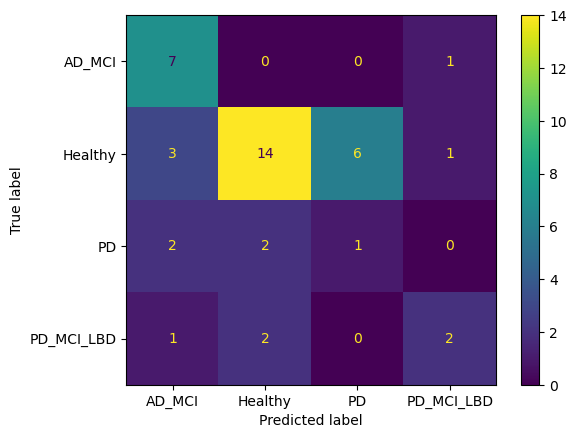

In [23]:
make_confusion_mtrx(dev, data_test, features=list_features)

# Using 18 features + Tau and AB42/40

score= 0.4833333333333334


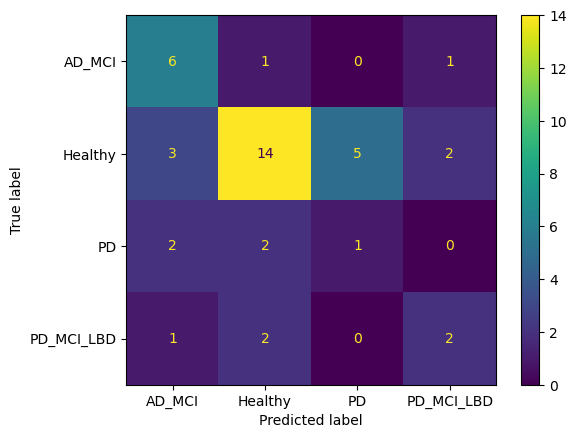

In [24]:
make_confusion_mtrx(dev, data_test, features=list_features_plus_biomarkers)

# Using 18 features + AB42/40

score= 0.5333333333333333


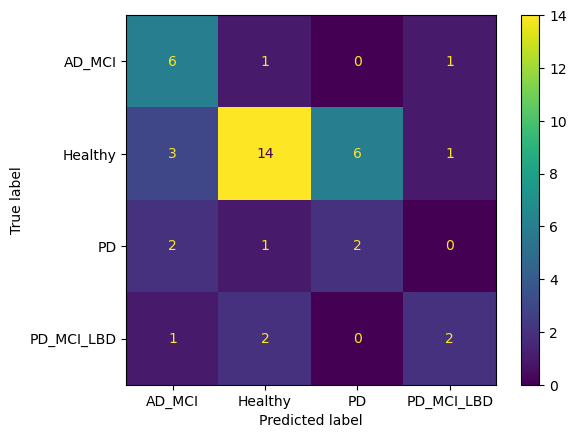

In [25]:
make_confusion_mtrx(dev, data_test, features=list_features_plus_ab42)

In [26]:
test_X = data_test[list_features]
test_y = data_test['group']

dev_X = dev[list_features]
dev_y = dev.iloc[:,0] # 0th column is our target

model = sklearn.ensemble.RandomForestClassifier()
model.fit(dev_X, dev_y) 
print(sklearn.metrics.balanced_accuracy_score(test_y, model.predict(test_X)))

0.4229166666666666


# "One vs. Rest" ROC curves 

In [ ]:
roc_curves_one_vs_rest(data_dev, data_test, list_features=list_features)

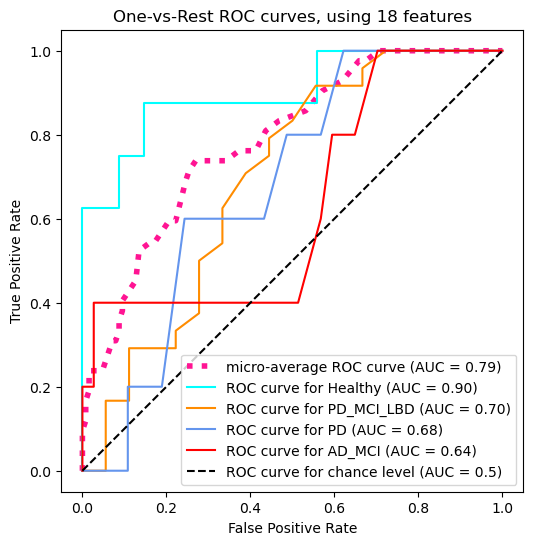

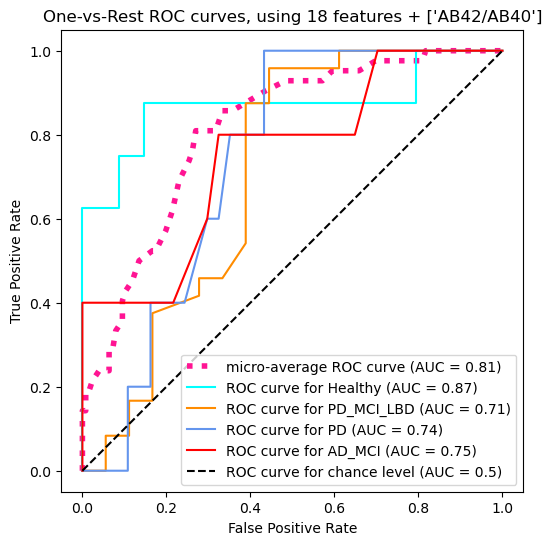

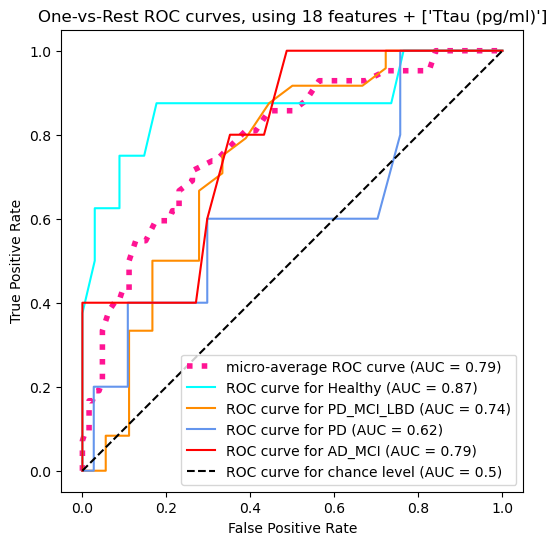

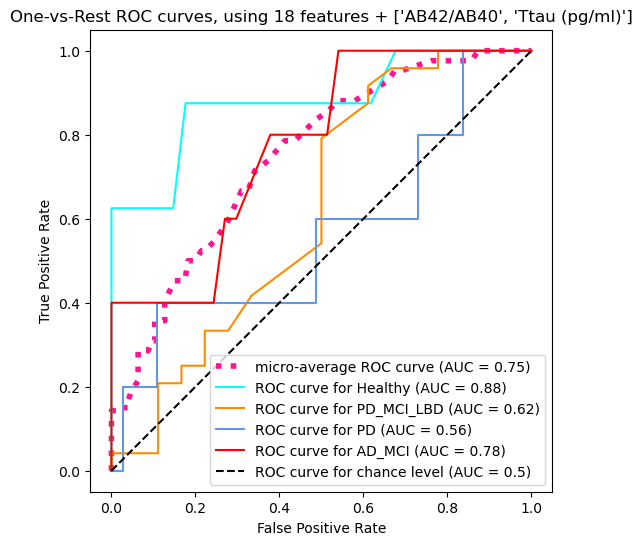

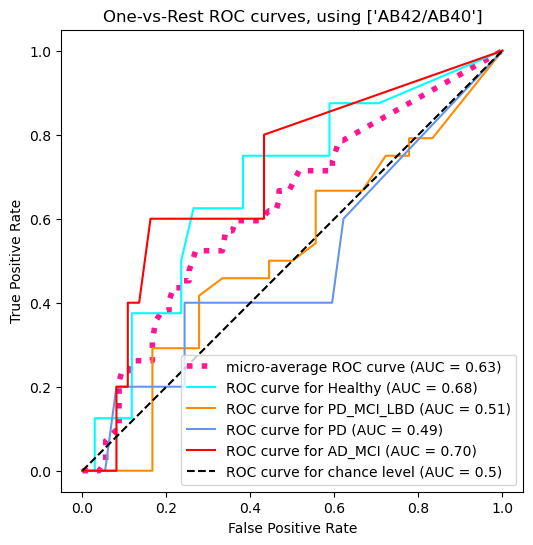

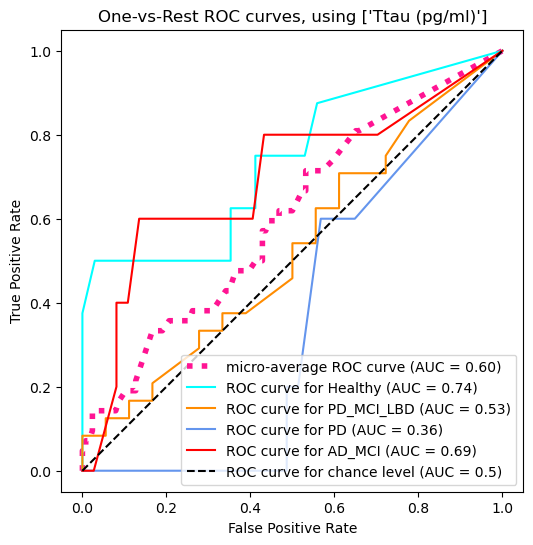

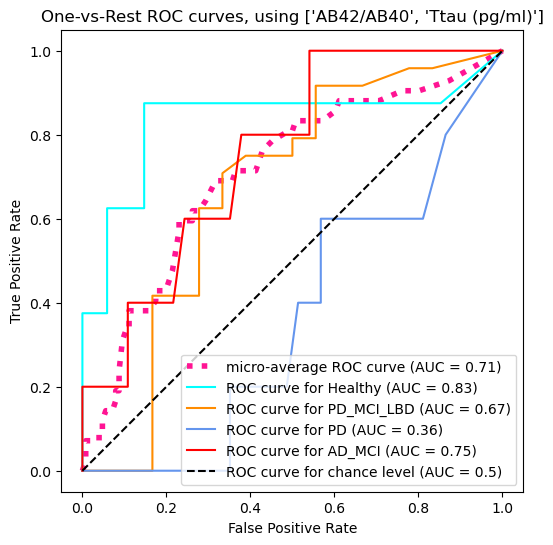

In [16]:
data_dev = pd.read_csv('/Users/mariamb/Desktop/BrainPower/brainpower/data/split_data/dev.csv')
data_test = pd.read_csv('/Users/mariamb/Desktop/BrainPower/brainpower/data/split_data/test.csv')
metadata = pd.read_csv('/Users/mariamb/Desktop/BrainPower/brainpower/data/metadata.csv')

data_dev, data_test = add_biomarkers_as_features(metadata, data_dev, data_test)


for i in feature_options: 
    roc_curves_one_vs_rest(data_dev, data_test, list_features=i)


# "One vs. One" ROC Curves

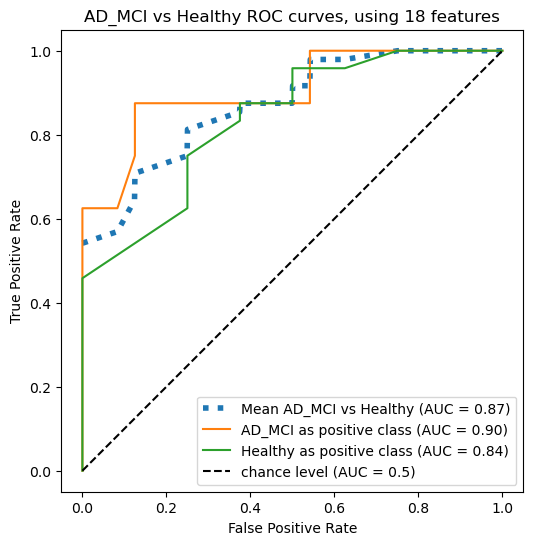

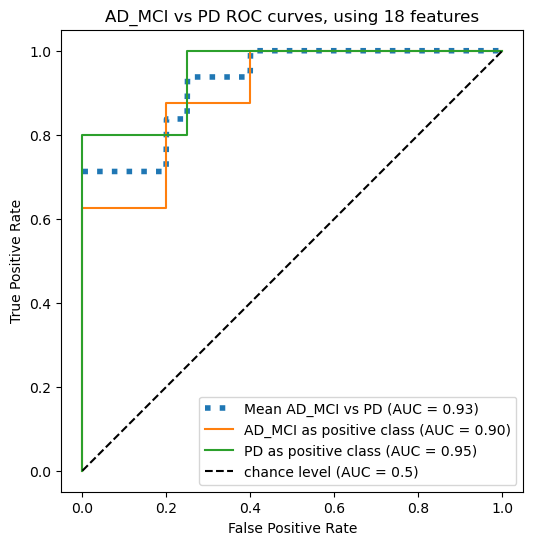

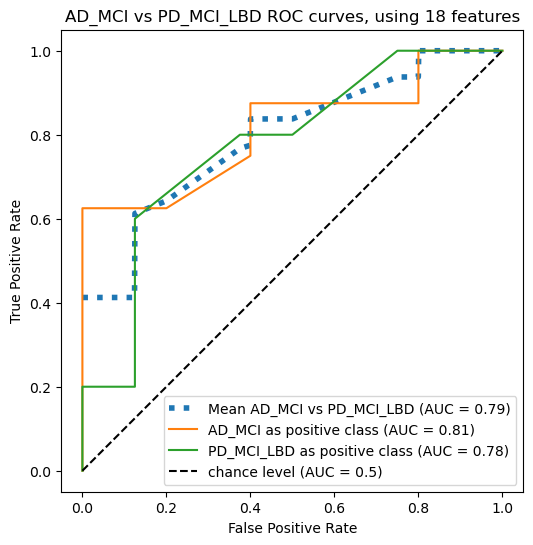

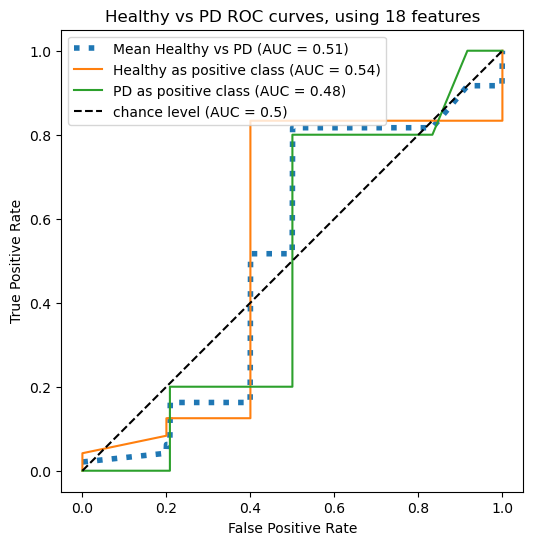

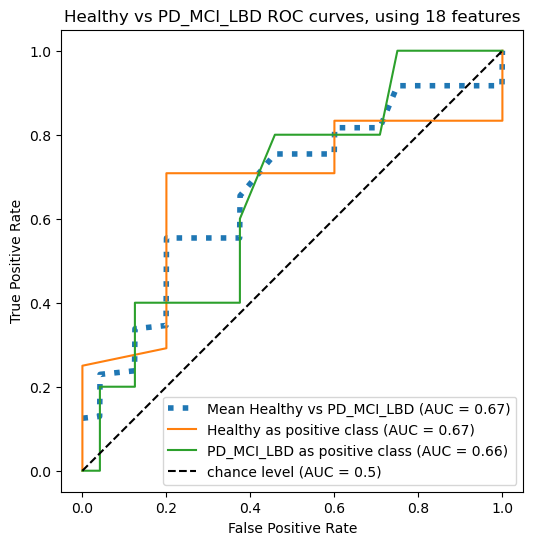

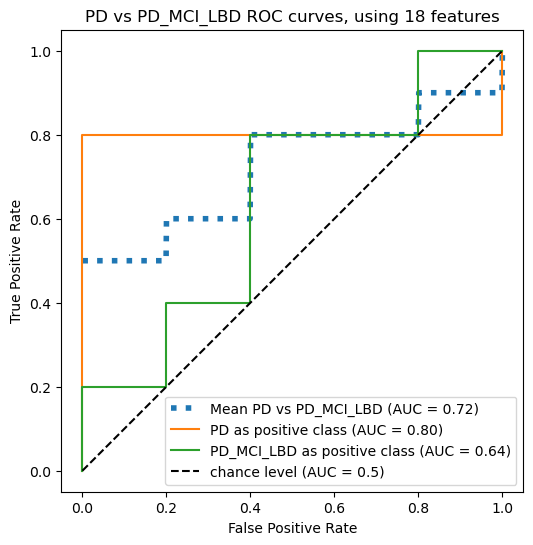

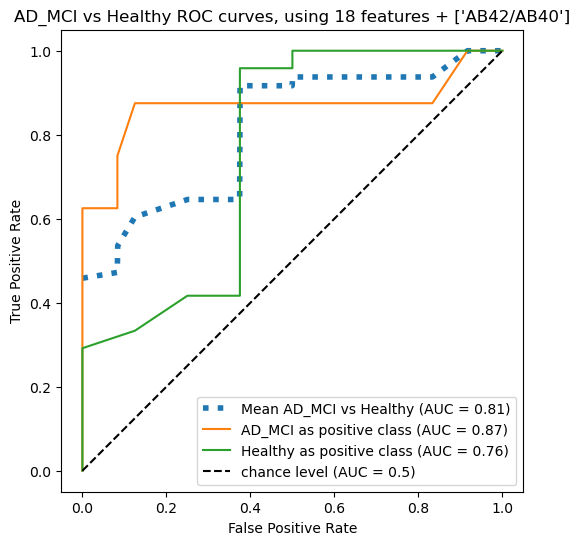

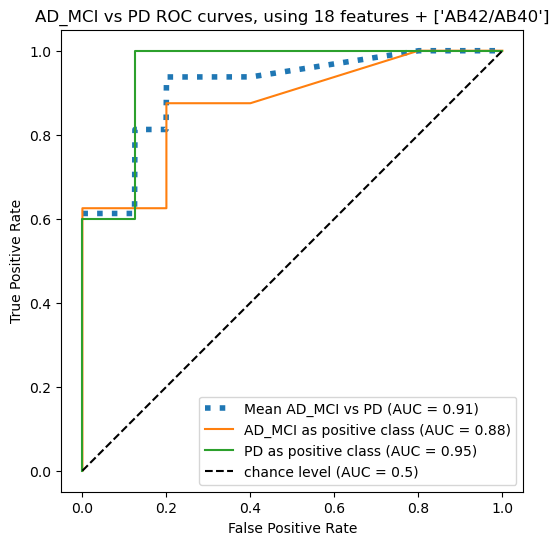

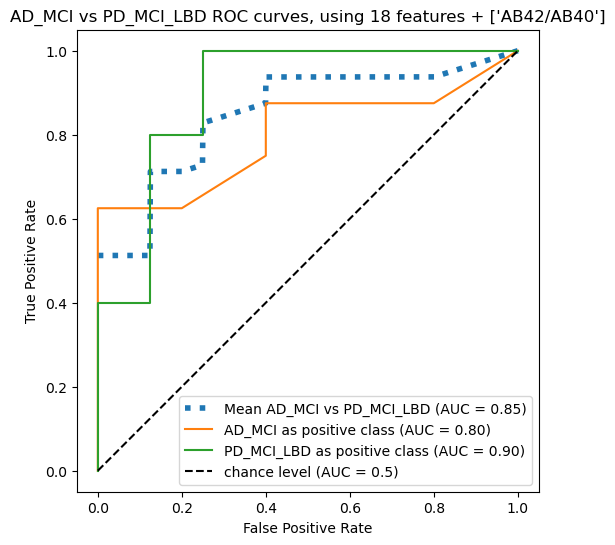

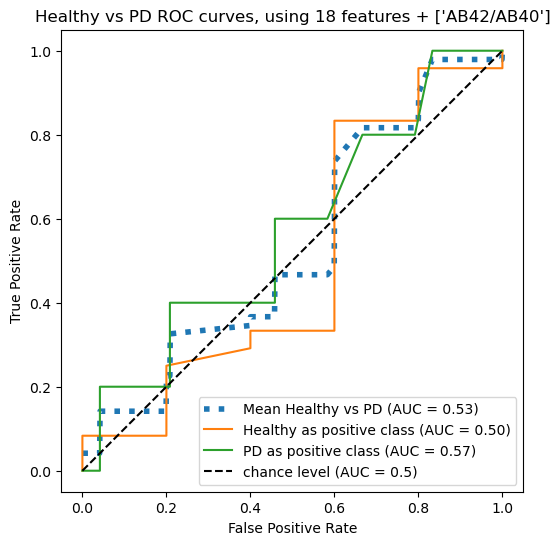

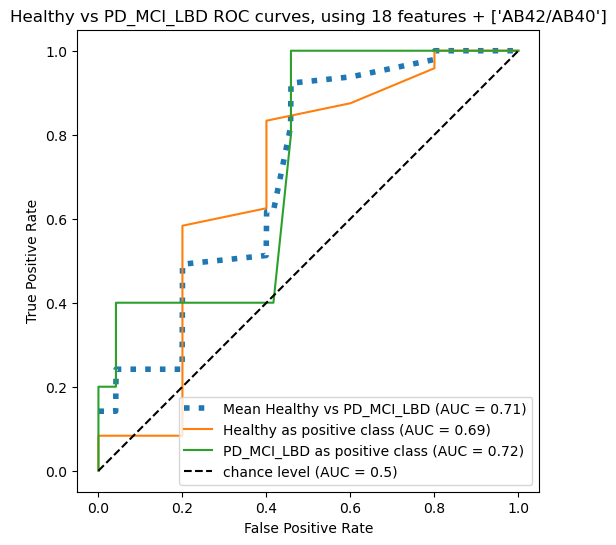

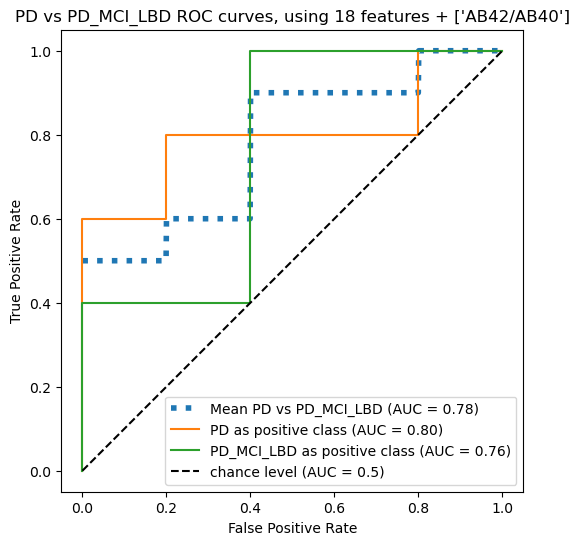

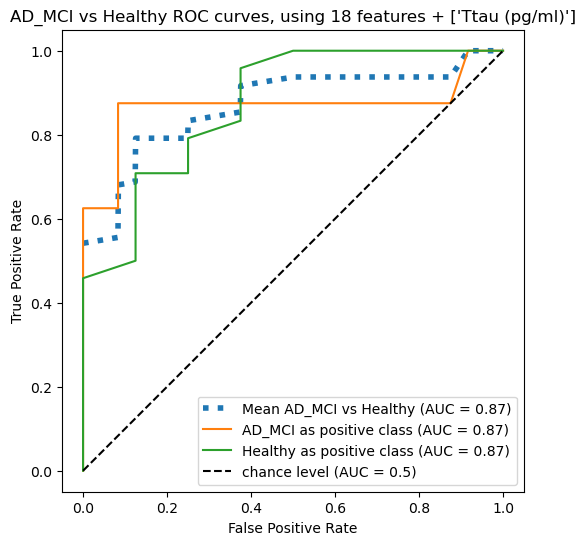

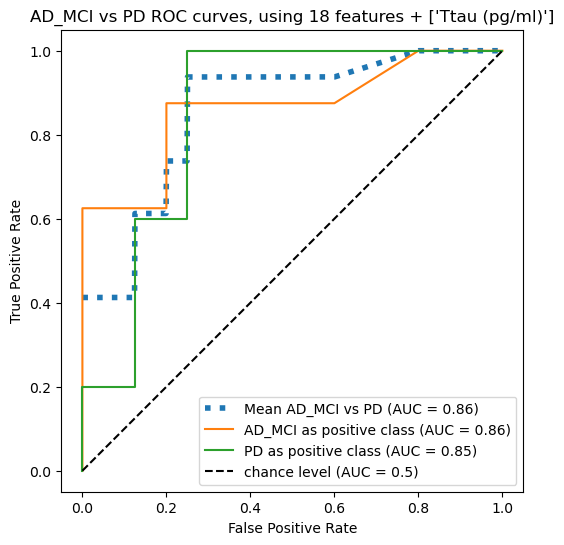

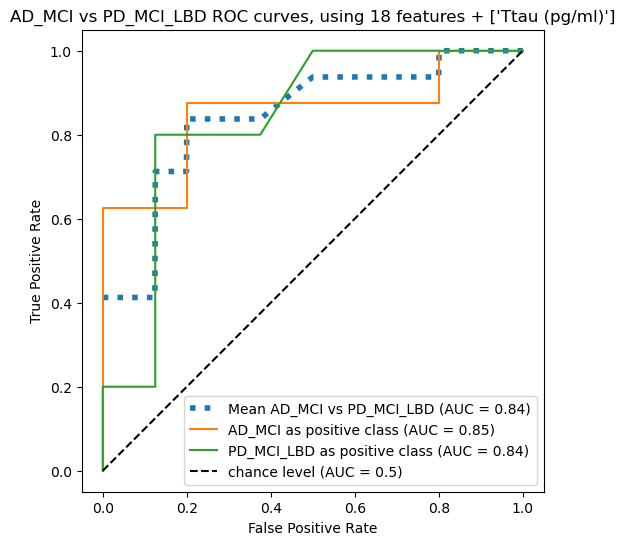

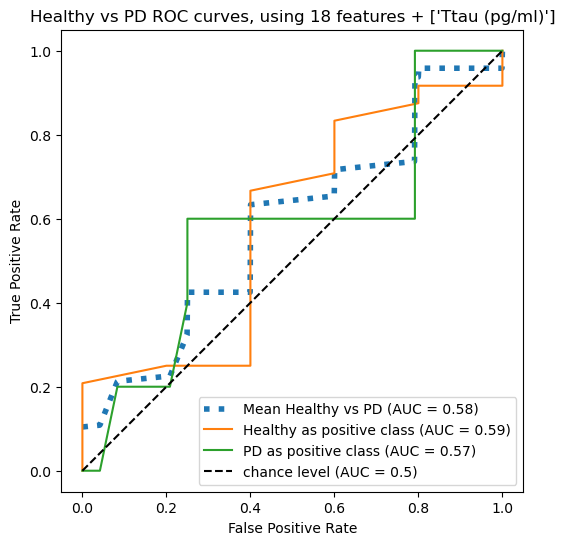

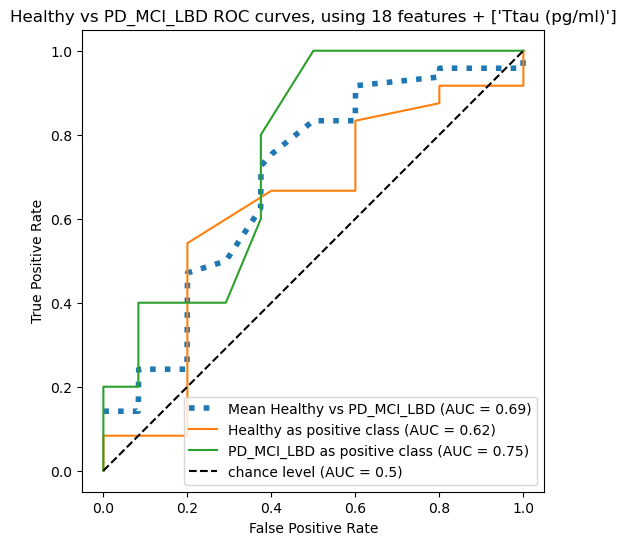

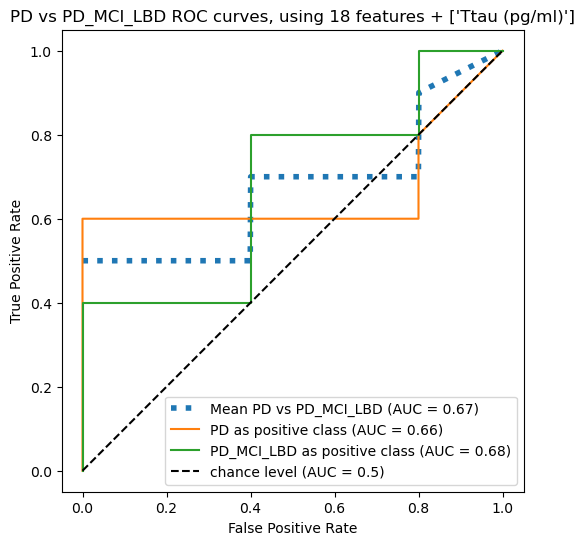

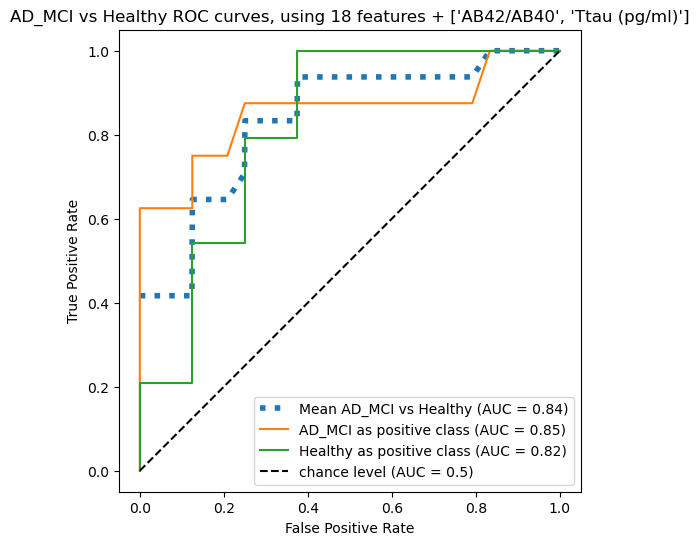

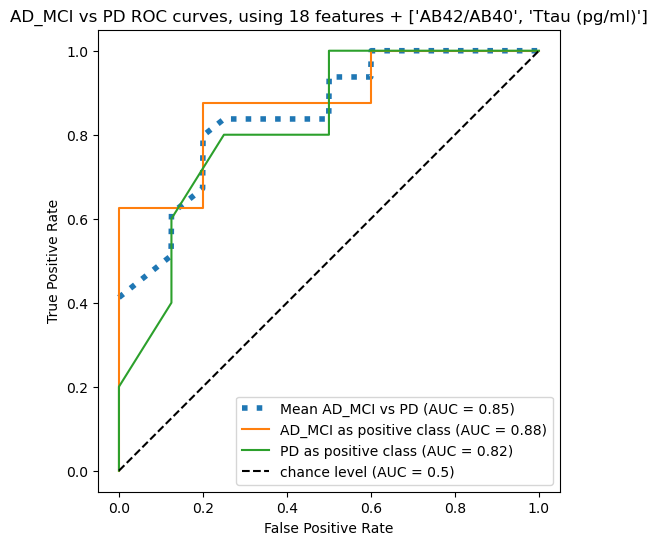

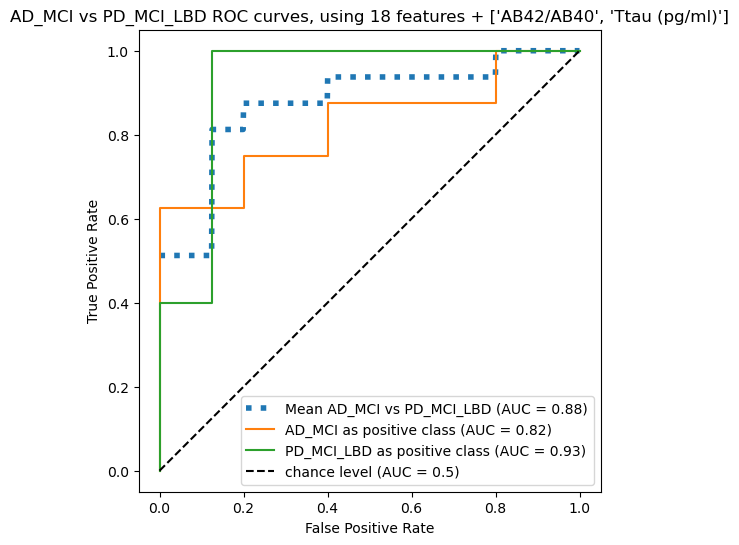

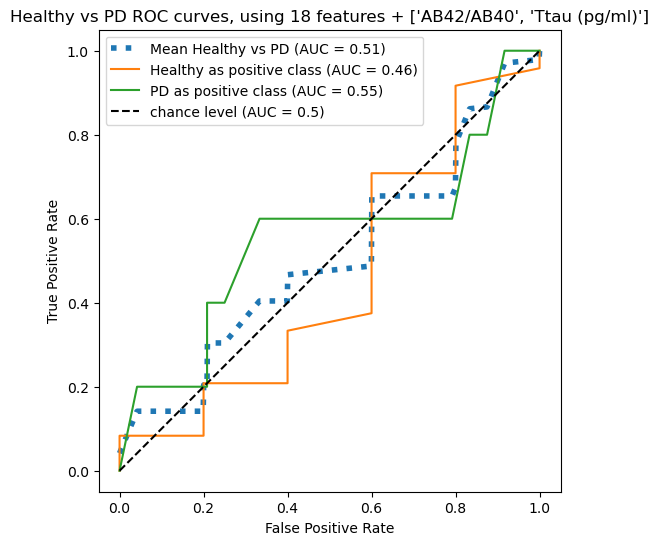

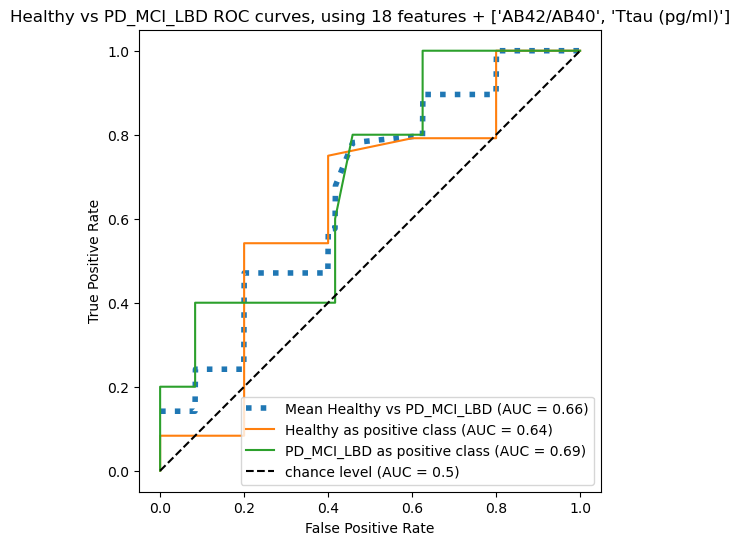

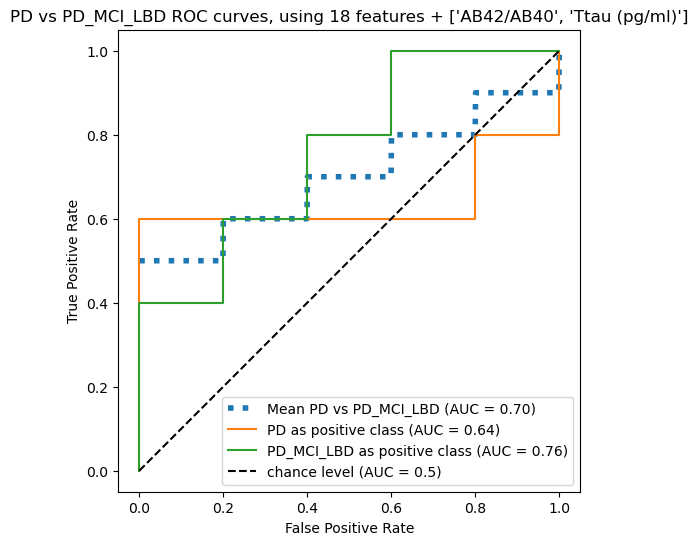

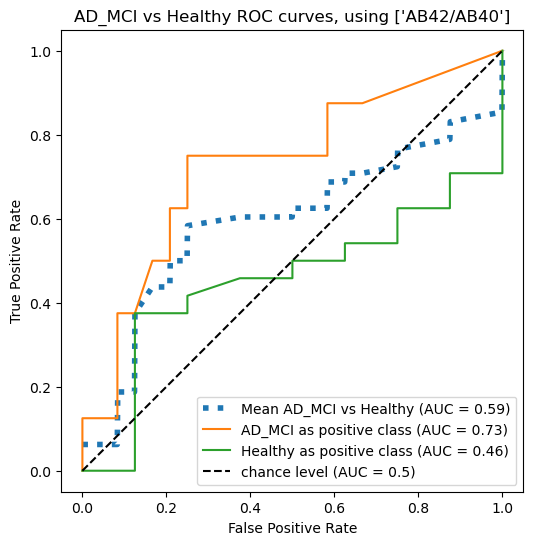

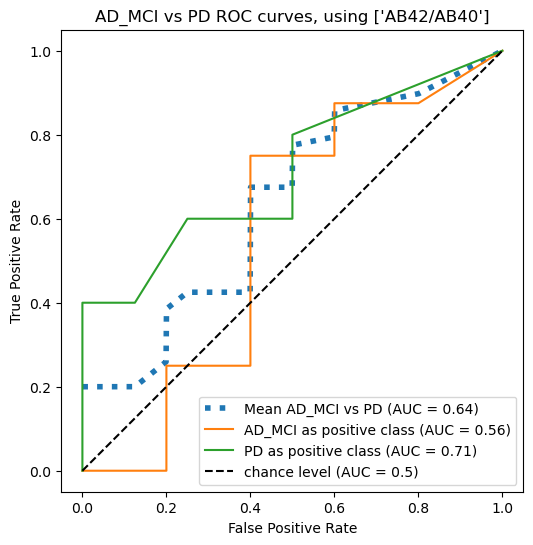

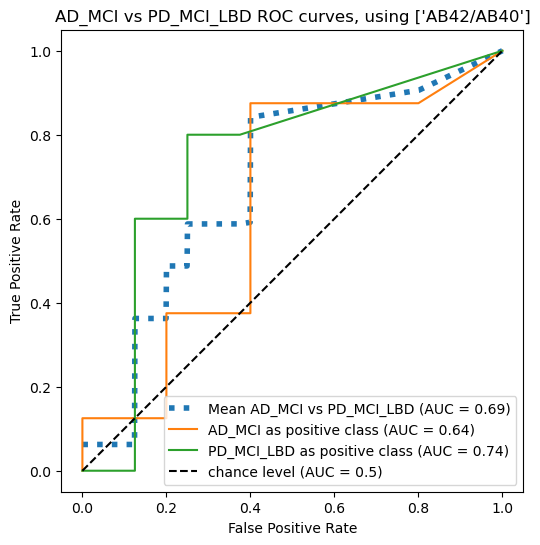

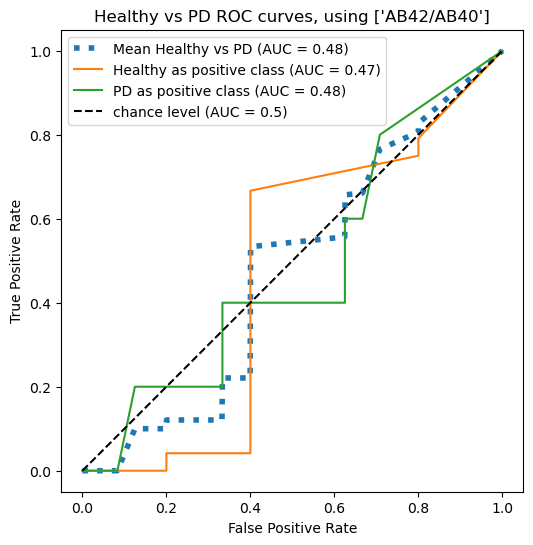

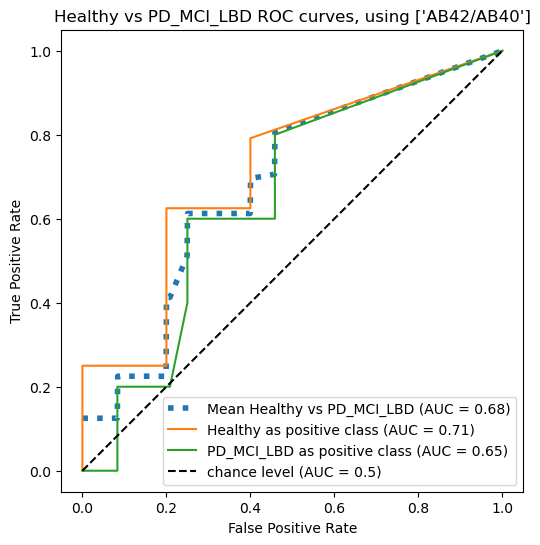

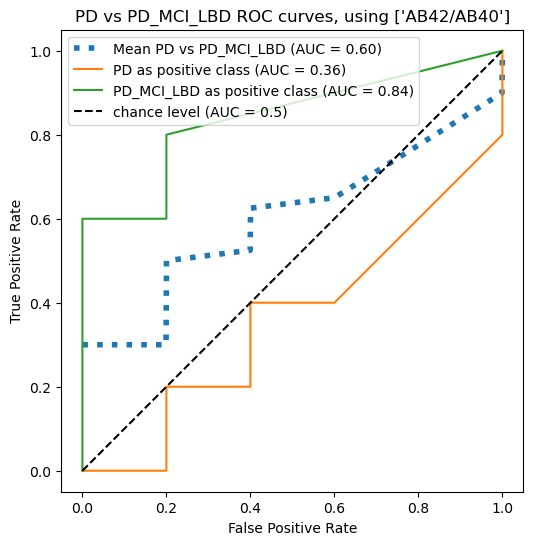

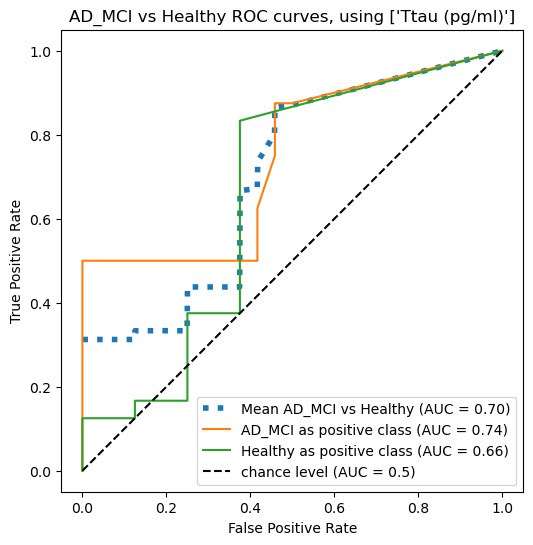

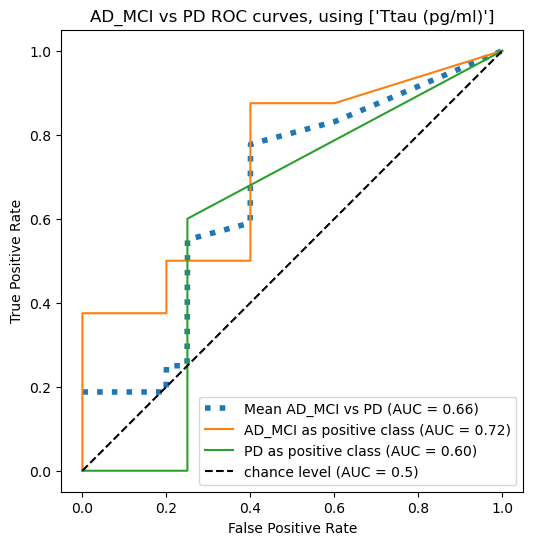

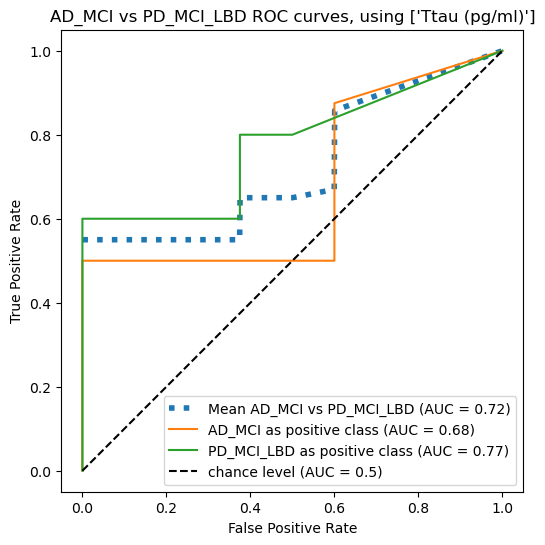

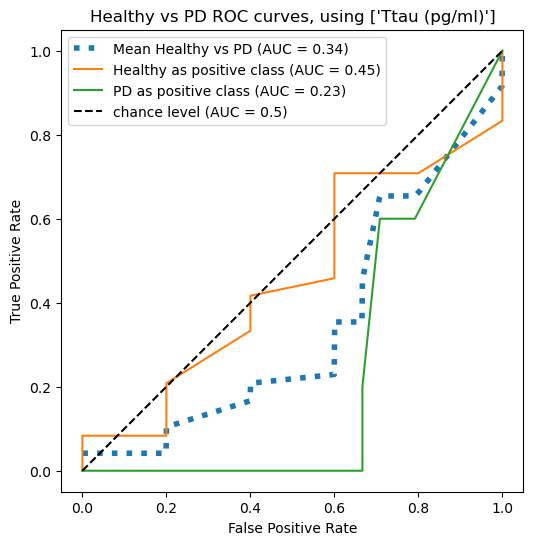

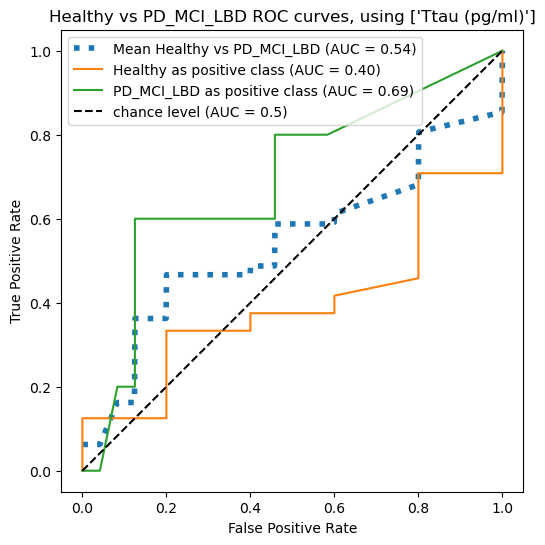

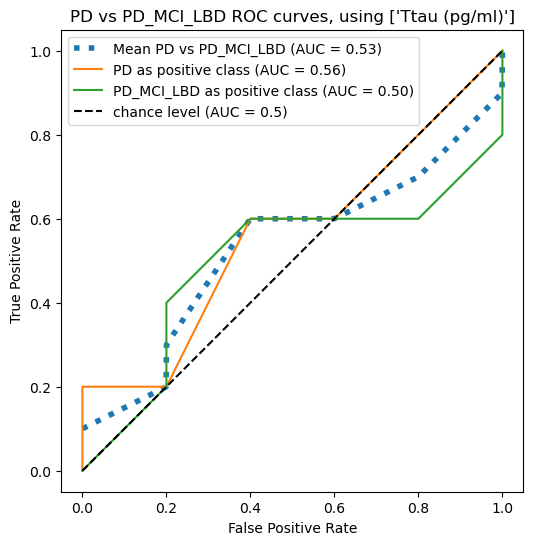

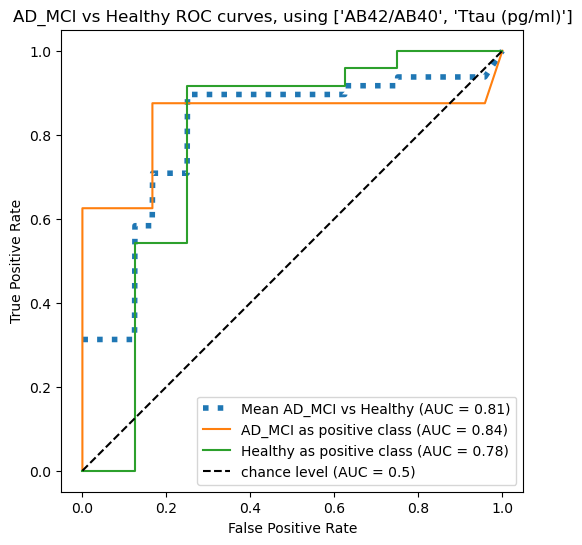

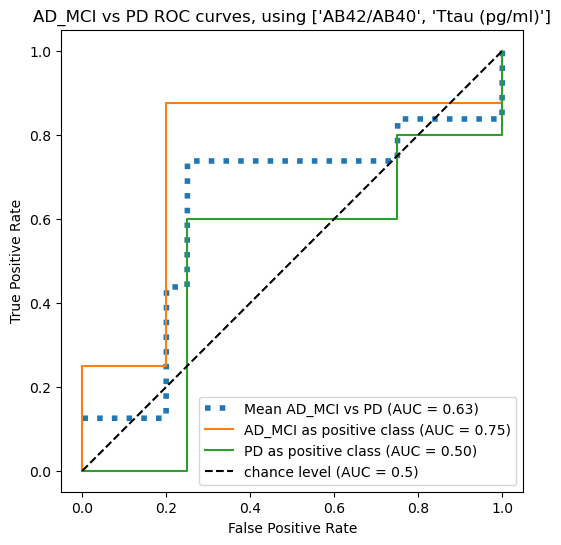

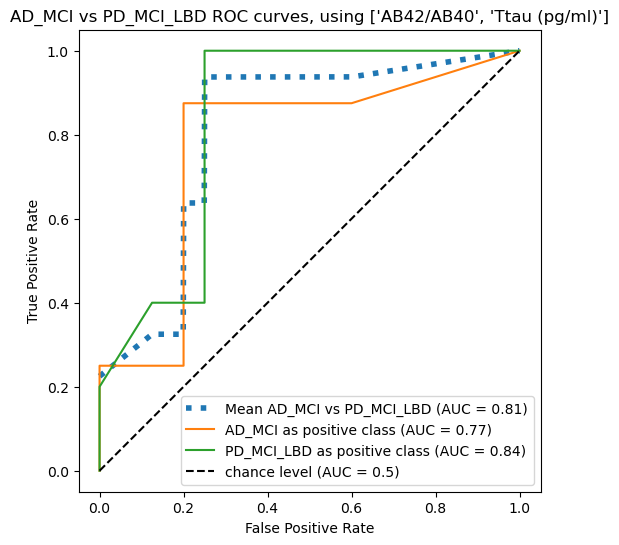

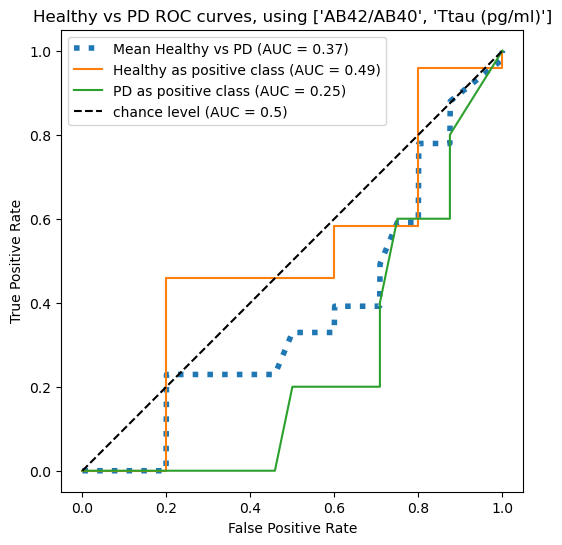

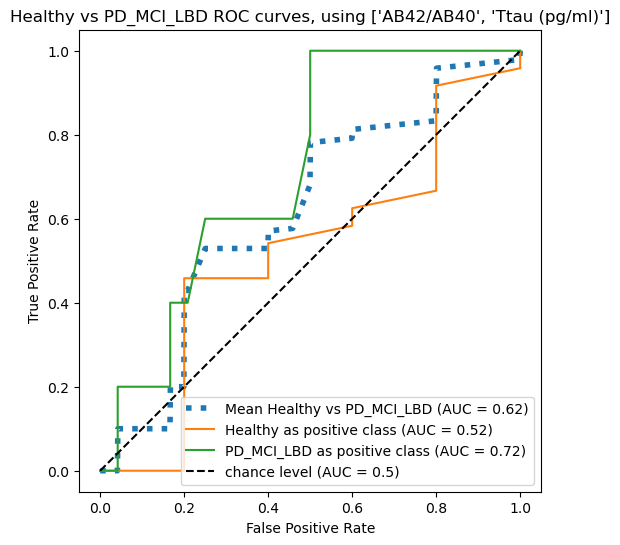

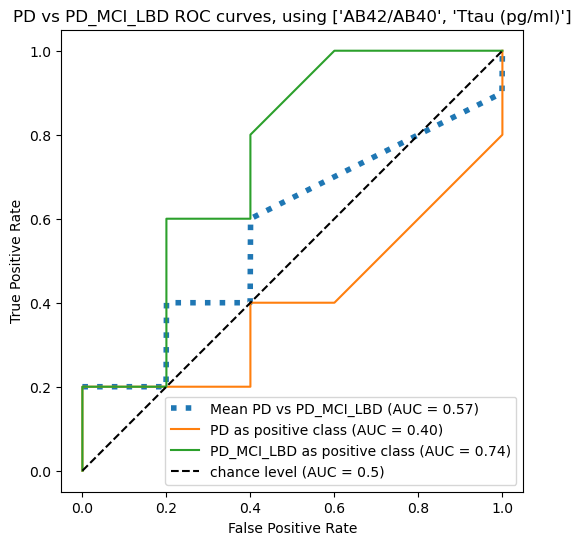

In [17]:
for i in feature_options: 
    roc_curve_one_vs_one(data_dev, data_test, i) #change features u choose